# Modelagem Preditiva de Doenças Isquêmicas
**Objetivo:** Prever a taxa de mortalidade e identificar quais fatores socioeconômicos mais impactam esse indicador.

## 1. Dicionário de Dados
| Variável | Tipo | Descrição | Papel no Modelo |
| :--- | :--- | :--- | :--- |
| **Taxa de Mortalidade** | Numérica | Mortes por 100k hab. | **Target (Alvo)** |
| **IDHM** | Numérica | Índice de Desenvolvimento Humano. | Feature |
| **Índice Gini** | Numérica | Desigualdade de renda. | Feature |
| **Leitos SUS** | Numérica | Leitos por habitante. | Feature |
| **Tabagismo** | Numérica | % de fumantes. | Feature |
| **PIB** | Numérica | % do PIB. | Feature |

## 2. Carregamento, Limpeza, Engenharia de Features e Preparação dos Dados

### Objetivo desta etapa:
- **Importar** os dados do CSV gerado na Fase 1
- **Criar** nova feature: `Regiao_Cod` (mapeamento de Estado para Região: 1-5)
- **Converter** valores textuais com vírgula (padrão PT-BR) para floats válidos
- **Garantir** que todas as colunas de features e targets estejam prontas para modelagem

### Detalhes:
1. Carrega `dataset_final_tratado.csv` com separator `;`
2. **Feature Engineering:** Cria coluna `Regiao_Cod` através da função `definir_regiao()` que mapeia estados às 5 regiões brasileiras
3. Define **features (6 variáveis independentes)**: IDHM, Gini, Leitos_SUS|10k, %_Fumantes, PIB_%, Regiao_Cod
4. Define **targets (2 variáveis alvo)**: Taxa Total e Taxa Adultos/Idosos
5. Converte tipos de dados: string → float (necessário para Machine Learning)
6. Exibe amostra dos dados preparados com `.head()`

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

#   Carregar dados
df = pd.read_csv('saidas_1_parte/dataset_final_tratado.csv', sep=';')

#   --- NOVA ETAPA: ENGENHARIA DE FEATURES (REGIÃO) ---
#   Função para transformar Estado em Região (Norte=1, Nordeste=2, etc.)
def definir_regiao(estado):
    norte = ['Amazonas', 'Roraima', 'Amapá', 'Pará', 'Tocantins', 'Rondônia', 'Acre']
    nordeste = ['Maranhão', 'Piauí', 'Ceará', 'Rio Grande do Norte', 'Paraíba', 'Pernambuco', 'Alagoas', 'Sergipe', 'Bahia']
    centro_oeste = ['Mato Grosso', 'Mato Grosso do Sul', 'Goiás', 'Distrito Federal']
    sudeste = ['São Paulo', 'Rio de Janeiro', 'Espírito Santo', 'Minas Gerais']
    sul = ['Paraná', 'Rio Grande do Sul', 'Santa Catarina']
    
    if estado in norte: return 1
    if estado in nordeste: return 2
    if estado in centro_oeste: return 3
    if estado in sudeste: return 4
    if estado in sul: return 5
    return 0

#   Aplicar a função para criar a coluna Regiao_Cod
df['Regiao_Cod'] = df['Estado'].apply(definir_regiao)

#   Definir features (variáveis independentes) - AGORA INCLUI A REGIÃO
features = ['IDHM', 'Gini', 'Leitos_SUS|10k', '%_Fumantes', 'PIB_%', 'Regiao_Cod']

#   Converter strings com vírgula para floats (apenas nas colunas originais que precisam)
cols_to_clean = ['IDHM', 'Gini', 'Leitos_SUS|10k', '%_Fumantes', 'PIB_%']
for col in cols_to_clean:
    if df[col].dtype == object:
        df[col] = df[col].str.replace(',', '.').astype(float)

#   Definir targets (variáveis dependentes)
targets = [
    'Taxa_Mortes_Isquemicas_Total_por_100k',
    'Taxa_Mortes_Isquemicas_Adultos_Idosos_por_100k'
]

#   Converter targets para float
for t in targets:
    if df[t].dtype == object:
        df[t] = df[t].str.replace(',', '.').astype(float)

#   saida
display(df[features + targets].head())

,IDHM,Gini,Leitos_SUS|10k,%_Fumantes,PIB_%,Regiao_Cod,Taxa_Mortes_Isquemicas_Total_por_100k,Taxa_Mortes_Isquemicas_Adultos_Idosos_por_100k
0,0.741,0.505,18.875153,13.8,-4.2,1,466.854923,365.919367
1,0.721,0.551,14.909705,13.6,-2.4,1,460.764038,335.256959
2,0.724,0.593,12.454125,10.6,-6.8,1,419.800048,294.452287
3,0.742,0.508,15.723420,14.2,0.2,1,414.914613,276.032670
4,0.668,0.578,13.120806,12.1,-4.0,1,466.073811,335.355078


## 3. Treinamento Inicial - Baseline Model (Random Forest sem otimização)

### Objetivo desta etapa:
- **Treinar** um modelo Random Forest simples com parâmetros padrão para cada target
- **Estabelecer** um baseline de desempenho (sem otimização de hiperparâmetros)
- **Comparar** a qualidade entre os dois targets: Total vs Adultos/Idosos
- **Guardar** X_test e y_test para análise posterior (SHAP)

### Detalhes:
1. Para cada target em `targets`, realiza:
   - Split 80/20 (treino/teste) com `random_state=42` para reprodutibilidade
   - Treina RandomForestRegressor com 100 árvores
   - Avalia performance no teste usando métrica R² (coeficiente de determinação)
   - Armazena modelo, X_test, y_test em dicionário `modelos_treinados`
2. Exibe scores para cada target para comparação inicial

In [2]:
#   Inicializar dicionário para baseline models
modelos_treinados = {}

print("=== INICIANDO TREINAMENTO AUTOMATIZADO ===")

for target_name in targets:
    print(f"\n>> Treinando modelo para prever: {target_name}")
    
    #   Preparar X (features) e y (target)
    X = df[features]
    y = df[target_name]
    
    #   Split 80/20 com random_state=42 para reprodutibilidade
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    #   Instanciar Random Forest com 100 árvores
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    #   Treinar no conjunto de treino
    rf_model.fit(X_train, y_train)
    
    #   Avaliar no conjunto de teste (métrica R²)
    score = rf_model.score(X_test, y_test)
    print(f"   Precisão do Modelo (R²): {score:.2%}")
    
    #   Armazenar modelo, X_test e y_test para análise posterior
    modelos_treinados[target_name] = {
        'modelo': rf_model,
        'X_test': X_test,
        'y_test': y_test
    }

print("\n=== TREINAMENTO CONCLUÍDO ===")

=== INICIANDO TREINAMENTO AUTOMATIZADO ===

>> Treinando modelo para prever: Taxa_Mortes_Isquemicas_Total_por_100k
   Precisão do Modelo (R²): 67.28%

>> Treinando modelo para prever: Taxa_Mortes_Isquemicas_Adultos_Idosos_por_100k
   Precisão do Modelo (R²): 77.61%

=== TREINAMENTO CONCLUÍDO ===


## 4. Otimização de Hiperparâmetros com GridSearchCV (Validação Cruzada 5-fold)

### Objetivo desta etapa:
- **Encontrar** a melhor combinação de hiperparâmetros para o modelo Random Forest
- **Usar** Validação Cruzada (5-fold) para garantir generalização (não apenas "sorte")
- **Superar** o desempenho do baseline através de ajuste fino
- **Seguir** o requisito: "Realizar ajuste fino dos modelos por meio de otimização de hiperparâmetros"

### Detalhes:
1. Define `param_grid` com combinações:
   - `n_estimators`: [100, 200] árvores de decisão
   - `max_depth`: [3, 4, 5] níveis de profundidade (limitados para evitar overfitting em dataset pequeno)
   - `min_samples_split`: [2, 4] amostras mínimas para dividir um nó
2. GridSearchCV testa **todas as 18 combinações** em **5 folds** para cada target
3. Valida que coluna `Regiao_Cod` existe antes de executar
4. Identifica e testa a melhor configuração nos dados de teste (nunca vistos)
5. Exibe: melhores parâmetros encontrados + score final R² + armazena em `melhores_modelos`

In [3]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor

# 1. Definindo a Grade de Parâmetros; profundidades causam overfitting.
param_grid = {
    'n_estimators': [100, 200],      
    'max_depth': [3, 4, 5],          # Quantidade limitada devido ao tamanho do dataset
    'min_samples_split': [2, 4]
}

# 2. Verificação de Segurança (Região)
cols_necessarias = ['IDHM', 'Gini', 'Leitos_SUS|10k', '%_Fumantes', 'PIB_%', 'Regiao_Cod']
features_validas = [c for c in cols_necessarias if c in df.columns]

if 'Regiao_Cod' not in features_validas:
    print("não encontrada. Certifique-se de rodar a célula que cria a região antes desta!")
else:
    print(f"Coluna 'Regiao_Cod' detectada! O modelo valido.")

# 3. Execução do Loop
melhores_modelos = {}

# Foca nos targets principais
targets_loop = [t for t in ['Taxa_Mortes_Isquemicas_Total_por_100k', 
                            'Taxa_Mortes_Isquemicas_Adultos_Idosos_por_100k'] if t in df.columns]

for target_name in targets_loop:
    print(f"\n>> Otimizando para: {target_name}...")
    
    # Preparação
    X = df[features_validas]
    y = df[target_name]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Modelo Base
    rf = RandomForestRegressor(random_state=42)
    
    # Grid Search
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                               cv=5, scoring='r2', verbose=0)
    
    grid_search.fit(X_train, y_train)
    
    # Resultados
    best_rf = grid_search.best_estimator_
    final_score = best_rf.score(X_test, y_test)
    
    print(f"   Melhores Parâmetros: {grid_search.best_params_}")
    print(f"   Score Final no Teste (R²): {final_score:.2%}")
    
    # Armazenar o melhor modelo
    melhores_modelos[target_name] = {
        'modelo': best_rf,
        'X_test': X_test,
        'y_test': y_test
    }

Coluna 'Regiao_Cod' detectada! O modelo valido.

>> Otimizando para: Taxa_Mortes_Isquemicas_Total_por_100k...
   Melhores Parâmetros: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
   Score Final no Teste (R²): 62.29%

>> Otimizando para: Taxa_Mortes_Isquemicas_Adultos_Idosos_por_100k...
   Melhores Parâmetros: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
   Score Final no Teste (R²): 74.19%


## 5. Explicabilidade e Interpretabilidade com SHAP (SHapley Additive exPlanations)

### Objetivo desta etapa:
- **Explicar** as predições do modelo (cumpre requisito: "Identificar quais fatores mais impactam")
- **Visualizar** o impacto de cada feature (IDHM, Gini, Leitos, Fumantes, PIB, Região)
- **Entender** como o modelo chega a suas decisões (não é uma "caixa preta")
- **Gerar** imagens PNG para documentação e relatório final

### Detalhes:
1. Inicializa JS do SHAP para visualizações interativas no Jupyter
2. Cria diretório `saidas_2_parte/` se não existir
3. Para cada modelo otimizado em `melhores_modelos`:
   - Instancia TreeExplainer (especializado em Random Forest)
   - Calcula valores SHAP para X_test (dados nunca vistos durante treinamento)
   - Gera Summary Plot mostrando:
     - **Eixo X**: Magnitude de impacto (quanto maior, mais influencia na predição)
     - **Cor**: Valor da feature (vermelho=alto, azul=baixo)
     - **Linhas**: Uma linha por feature, ordenada por importância média
4. Salva PNG em `saidas_2_parte/shap_summary_*.png` para uso posterior

C:\Users\joaog\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


   Gráfico salvo: saidas_2_parte/shap_summary_taxa_mortes_isquemicas_total_por_100k.png


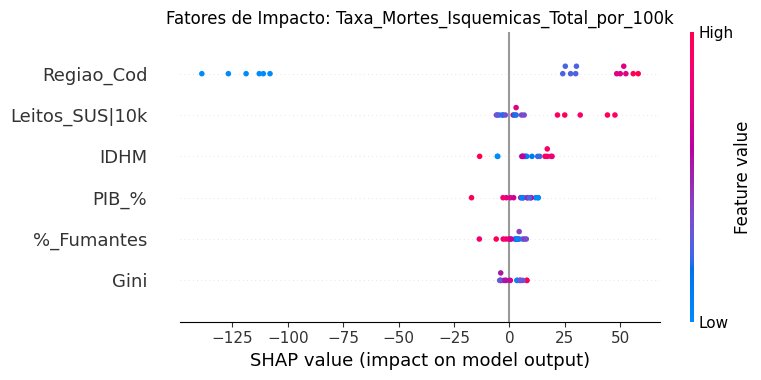

   Gráfico salvo: saidas_2_parte/shap_summary_taxa_mortes_isquemicas_adultos_idosos_por_100k.png


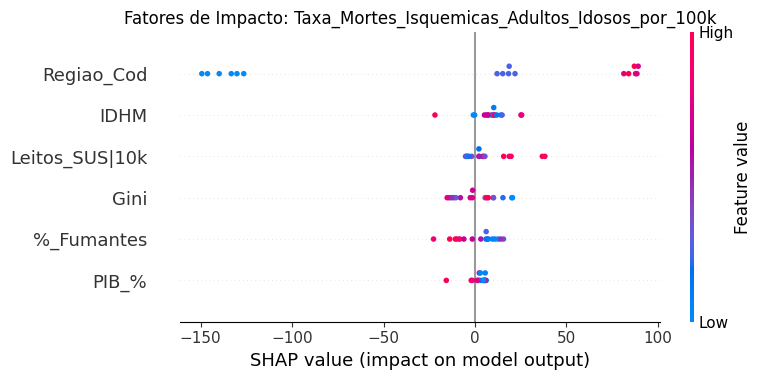

In [4]:
import shap
import matplotlib.pyplot as plt
import os

#   Inicializar JS para visualizações interativas no Jupyter
shap.initjs()

#   Criar diretório 'saidas_2_parte' se não existir
if not os.path.exists('saidas_2_parte'):
    os.makedirs('saidas_2_parte')

#   Inicializar dicionário para armazenar valores SHAP
shap_results = {}

for target_name, dados in melhores_modelos.items():
    
    #   Recuperar modelo e dados de teste
    modelo_campeao = dados['modelo']
    X_test = dados['X_test']
    
    #   Instanciar TreeExplainer (otimizado para Random Forest)
    explainer = shap.TreeExplainer(modelo_campeao)
    
    #   Calcular valores SHAP
    shap_values = explainer.shap_values(X_test, check_additivity=False)
    shap_results[target_name] = shap_values
    
    #   Gerar summary plot (visualização principal)
    plt.figure(figsize=(10, 6))
    plt.title(f"Fatores de Impacto: {target_name}")
    shap.summary_plot(shap_values, X_test, show=False)
    
    #   Salvar imagem e exibir
    nome_arquivo_img = f"saidas_2_parte/shap_summary_{target_name.replace(' ', '_').replace('/', '_').lower()}.png"
    plt.savefig(nome_arquivo_img, bbox_inches='tight')
    print(f"   Gráfico salvo: {nome_arquivo_img}")
    plt.show()

## 6. Serialização e Persistência dos Modelos Otimizados (Armazenamento em .pkl)

### Objetivo desta etapa:
- **Serializar** os modelos treinados em formato `.pkl` (pickle binary)
- **Permitir** que o Dashboard Streamlit carregue instantaneamente (sem retrainamento)
- **Separar** fase de treinamento da fase de predição (MLOps best practice)
- **Garantir** reproducibilidade: modelos salvos com `random_state=42` são determinísticos

### Detalhes:
1. Cria diretório `modelos/` se não existir
2. Para cada modelo otimizado em `melhores_modelos`:
   - Limpa nome do target: remove espaços, barras e converte a minúsculas
   - Gera caminho: `modelos/modelo_{nome_limpo}.pkl`
   - Serializa o modelo com `joblib.dump()`
   - Exibe confirmação de sucesso
3. **Resultado final**: 2 arquivos .pkl prontos para carregamento no app.py
   - `modelo_taxa_mortes_isquemicas_total_por_100k.pkl`
   - `modelo_taxa_mortes_isquemicas_adultos_idosos_por_100k.pkl`

In [5]:
import joblib
import os

#   Criar diretório 'modelos' se não existir
if not os.path.exists('modelos'):
    os.makedirs('modelos')

for target_name, dados in melhores_modelos.items():
    modelo = dados['modelo']
    
    #   Limpar nome do arquivo (remove caracteres especiais)
    nome_limpo = target_name.replace(' ', '_').replace('/', '_').lower()
    caminho_arquivo = f'modelos/modelo_{nome_limpo}.pkl'
    
    #   Serializar modelo para arquivo .pkl
    joblib.dump(modelo, caminho_arquivo)
    print(f" Modelo salvo com sucesso em: {caminho_arquivo}")

# Agora o Dashboard carrega esses arquivos instantaneamente.

 Modelo salvo com sucesso em: modelos/modelo_taxa_mortes_isquemicas_total_por_100k.pkl
 Modelo salvo com sucesso em: modelos/modelo_taxa_mortes_isquemicas_adultos_idosos_por_100k.pkl
